In [1]:
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tesser import util
from tesser import figures

data_dir = '/Users/morton/Dropbox/tesser_successor/Data'
fig_dir = '/Users/morton/Dropbox/tesser_successor/Figures/plots'

In [2]:
induct = util.load_induct(data_dir)
induct.head()

,subject,trial,trial_type,environment,community,cue,opt1,opt2,response,response_time,correct
0,100,1,central,ocean,1,2,16,20,<NA>,NaN,0
1,100,2,boundary2,desert,2,4,10,19,2,2.974157,0
2,100,3,central,desert,2,5,6,2,1,3.190848,1
3,100,4,central,ocean,1,2,9,19,2,3.373906,1
4,100,5,central,ocean,1,1,19,13,2,3.094699,0


In [3]:
m = (induct.groupby(['subject', 'trial_type'])['correct'].mean() - .5) * 2

In [4]:
dark = sns.blend_palette(
    [
        np.array([20, 125, 201]) / 256, 
        np.array([0, 166, 161]) / 256, 
        np.array([15, 175, 75]) / 256,
    ], n_colors=3
)
dark

[(0.078125, 0.48828125, 0.78515625),
 (0.00022977941176470588, 0.6485753676470588, 0.6275888480392157),
 (0.05859375, 0.68359375, 0.29296875)]

In [5]:
light = sns.blend_palette(
    [
        np.array([171, 212, 237]) / 256, 
        np.array([172, 235, 242]) / 256, 
        np.array([165, 232, 177]) / 256,
    ], n_colors=3
)
light

[(0.66796875, 0.828125, 0.92578125),
 (0.6717677696078431, 0.9179227941176471, 0.9443167892156863),
 (0.64453125, 0.90625, 0.69140625)]

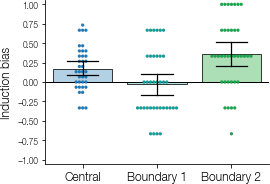

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))
figures.plot_swarm_error(m, x='trial_type', y='correct', dark=dark, light=light, ax=ax)
ax.set(
    ylim=(-1.05, 1.05), ylabel='Induction bias',
    xticklabels=['Central', 'Boundary 1', 'Boundary 2']
)
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim)
ax.set_xlim(*x_lim);
fig.savefig(os.path.join(fig_dir, 'temporal_bias.pdf'))